In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import pandas as pd
import sklearn.datasets

# Metrics for supervised machine learning

The general problem supervised machine learning seeks to solve is to map a measurement of several variables to a target value or class. For example, we might use supervised machine learning to transcribe spoken language to text, predict home values based on neighborhood amenities, or detect fraudulent transactions. In order to assess whether our model is succeeding, we need to formally define what success is for the given task. In this notebook, we will explore several common **metrics** for model performance.

## Mathematics of supervised learning

For most machine-learning problems, our model receives a vector of **features**, $X$, and maps it to some predicted label, $y$. In order to train our model, we will need many **observations** (i.e. measurements) and their associated labels. We can assemble these observations into a matrix.

$$ f(X_{ij}) \approx y_i $$

We'll use the California housing data set as an example. The California housing data set has measurements of average house age, average number of rooms, location, and other qualities for various census blocks of California.

In [3]:
!wget http://dataincubator-wqu.s3.amazonaws.com/caldata/cal_housing.pkz -nc -P ~/scikit_learn_data/

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from sklearn.datasets import fetch_california_housing

cali_data = fetch_california_housing()

print(cali_data.DESCR)

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)
cali_df.head()

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In the above dataframe, each column is a feature (i.e. a variable) and each row is an observation (i.e. a measurement). Said another way, things like median income and average number of rooms are features, while each census block for which we have a measurement of the features is an observation. We also have a vector of target labels, which is the median home value for each neighborhood. Altogether we have 9 features and 20640 observations with labels.

In [5]:
print(cali_data.data.shape)
print(cali_data.target.shape)

(20640, 8)
(20640,)


When we design a model to predict real number values (e.g. home price), our model is a **regression model**. Alternatively, we could design a model to predict categorical labels, such as "expensive neighborhood" and "inexpensive neighborhood". This would be a **classification model**. Most supervised machine learning tasks fall into the category of **regression** or **classification**. In either case we have to define a metric that quantifies what we mean by $\approx$ in the equation above.

We use our metric to define a **cost function** (let's call it $C$). To carry out gradient descent, we numerically evaluate the derivative of $C$ with respect to our model parameters.

$$ \frac{dC}{df} = \nabla_f C = \left(\frac{\partial C}{\partial \Theta_1}, \frac{\partial C}{\partial \Theta_2}, ...\right) $$

Often the cost function, $C$, will be the same as our metric, but sometimes it may have additional terms, which we will explore later.

## Metrics for regression tasks

In the [notebook on linear regression](ML_LinearRegression.ipynb) we introduced mean squared error (MSE) as a metric for how our trend line was performing. This lead us to define a cost function, a scalar function that depends on our model parameters. We minimized the cost function using gradient descent. Depending on what problem we are trying to solve and what we want to optimize, we may choose different metrics.

**Mean squared error** (MSE) is one of the most common metrics for regression:

$$ \frac{1}{n}\sum_i\left[f(X_i) - y_i\right]^2 $$

We squared the error terms ($f(X_i) - y_i$) because we didn't care whether they were positive or negative. We could have also addressed this concern by taking the absolute value, which would lead to the **mean absolute error** (MAE)

$$ \frac{1}{n}\sum_i|f(X_i) - y_i| $$

When we minimize the MAE by adjusting our model parameters, our model will be less strongly affected by outliers than if we used the MSE. This is because the error terms from outliers (which will generally be large) enter into the MAE a linear terms rather than being squared.

Another common metric for regression is $R^2$, also known as the **coefficient of determination**. The $R^2$ quantifies how our model's MSE compares to a naive model in which we always predict the mean $y$ value, $\bar{y}$.

$$ 1 - \frac{\sum_i \left[f(X_i) - y_i\right]^2}{\sum_i\left(\bar{y} - y_i\right)^2} $$

If our $R^2 < 0$ we know our model is very bad, because the MSE is larger than than the MSE of the mean model.

One important consideration when choosing a metric is how they scale with the data.

In [7]:
from sklearn import metrics
import numpy as np

y = np.random.randn(10)
y_pred = y + .5 * np.random.randn(10)

print('MSE: %f' % metrics.mean_squared_error(y, y_pred))
print('MAE: %f' % metrics.mean_absolute_error(y, y_pred))
print('R^2: %f' % metrics.r2_score(y, y_pred))

MSE: 0.379185
MAE: 0.541616
R^2: 0.596714


In [8]:
# rescale y

y = 2 * y
y_pred = 2 * y_pred

print('MSE: %f' % metrics.mean_squared_error(y, y_pred))
print('MAE: %f' % metrics.mean_absolute_error(y, y_pred))
print('R^2: %f' % metrics.r2_score(y, y_pred))

MSE: 1.516738
MAE: 1.083231
R^2: 0.596714


## Metrics for classification tasks

The metrics for regression rely on calculating an error term (i.e. the difference between our prediction and the ground truth). We can't do this for a classification task, so we will need to define entirely different metrics for classification. Let's start with the possible outcomes when we make a prediction.

|                        | Actual positive | Actual negative |
|------------------------|:---------------:|:---------------:|
| **Predicted positive** |  True positive  |  False positive |
| **Predicted negative** |  False negative |  True negative  |

We have four possible outcomes we can use build our metric. We'll consider only three possibilities (though many more metrics have been defined).

**Accuracy** is the most intuitive: it is the amount of proportion of true positives and negatives. We add up the true positives and true negatives and divide by the total number of predictions.

Accuracy suffers from tasks in which there is class imbalance. For instance, in fraud detection, actual positives are very rare. Therefore, we could get high accuracy by simply always predicting negative. If only 0.1% of all observations are actually positive, then a model that always predicts negative gets 99.9% accuracy, even though this is clearly a bad model for detecting fraud.

This example illustrates that we often care about one class more than another. For instance, if we think a transaction is fraudulent, we might waste some resources investigating it, but missing a case of fraud could cost much more. In this case we might want most to avoid false negatives.

**Recall** is the count of true positives divided by the count of _actual positives_. Recall will be close to 1 as long as the count of false negatives is low, even if there are not many actual positives.

On the other hand, if a fraud case goes to trial, we do not want to punish a defendant unfairly. In that case it's important to avoid false positives. **Precision** is the count of true positives divided by the count of positive predictions. As long as the count of false positives is low, precision will be close to 1.

In [7]:
y = [0, 0, 1, 0, 1, 1, 0, 1]
y_pred = [0, 1, 1, 0, 1, 1, 0, 1]

print('Accuracy: %f' % metrics.accuracy_score(y, y_pred))
print('Recall: %f' % metrics.recall_score(y, y_pred))
print('Precision: %f' % metrics.precision_score(y, y_pred))

Accuracy: 0.875000
Recall: 1.000000
Precision: 0.800000


## Precision-recall tradeoff

There is a tradeoff between precision and recall as we adjust our model, exchanging positive predictions for negative predictions.

Often our classification model won't predict whether an observation is in one class or another, but rather will predict the _probability_ of the observation being in one class or the other. We choose a threshold probability, above which we will predict the observation is in the positive class, and below which we'll predict negative.

In [9]:
p_pred = np.linspace(0, 1, 1000)
y = np.random.binomial(1, p_pred)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact

def plot_threshold(threshold=0.5):
    true_pos = (p_pred > threshold) & (y == 1)
    true_neg = (p_pred < threshold) & (y == 0)
    false_pos = (p_pred > threshold) & (y == 0)
    false_neg = (p_pred < threshold) & (y == 1)

    plt.plot(p_pred[true_pos], y[true_pos], '.', label='True positive')
    plt.plot(p_pred[false_pos], y[false_pos], '.', label='False positive')
    plt.plot(p_pred[true_neg], y[true_neg], '.', label='True negative')
    plt.plot(p_pred[false_neg], y[false_neg], '.', label='False negative')

    plt.axvline(threshold)
    plt.ylim(-0.25, 1.25)
    plt.legend()

    precision = 1
    if (p_pred > threshold).sum() > 0:
        precision = float(true_pos.sum()) / (true_pos.sum() + false_pos.sum())
    recall = float(true_pos.sum()) / (true_pos.sum() + false_neg.sum())

    plt.title('Precision: %0.2f | Recall: %0.2f' % (precision, recall))

interact(plot_threshold, threshold=(0, 1, 0.1));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…

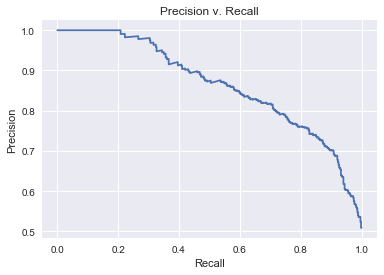

In [10]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y, p_pred)

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision v. Recall');

We can summarize this curve in a single number: the area under the curve. If our model were perfect, precision and recall would both be 1 regardless of threshold, so the area under the curve would be 1. If our model was always wrong, the precision and recall would both be 0 regardless of threshold, so the area under the curve would be 0. The better our model is, _regardless of threshold_, the closer the area under the curve is to 1. We eventually need to a choose a threshold and may choose to prioritize precision or recall, but the **area under the precision-recall curve** (AUC), is a very useful metric for assessing model performance in classification tasks.

*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*